In [10]:
import torch
from torcheval.metrics.functional import binary_accuracy
import matplotlib.pyplot as plt
import numpy as np
# Add the directory above the current notebook's directory to the system path
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))
from datasets import load_circles_dataset

### PLot functions

In [11]:
def plot_scatter(X:np.ndarray, Y:np.ndarray):
    '''
    Show the scatter plot of flower dataset
    
    Parameters
    ----------
    X : numpy.ndarray [shape: (#features, #samples)]
        matrix of data; dtype: float64
    Y : numpy.ndarray [shape: (1, #samples)]
        array containing true labels 0 or 1; dtype: uint8 
    '''
    scatter=plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)
    plt.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    plt.xlabel('feature 1')
    plt.ylabel('feature 2')
    # plt.show()
    

def plot_decision_boundary(predict, X, Y):
    """
    Plot the decision boundary for logistic regression
    
    Parameters
    ----------
    predict : function
        predicted output; dtype=int8 
    parameters : dict
    X : numpy.ndarray [shape: (#features, #samples)]
        matrix of data; dtype: float64
    Y : numpy.ndarray [shape: (1, #samples)]
        array containing true labels 0 or 1; dtype: uint8
    """
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    # Y = None argument is dumpy as not used when print_accuracy=False
    Z = predict(torch.tensor(np.c_[xx.ravel(), yy.ravel()],dtype=torch.float32))
    Z=(Z > 0.5).type(torch.float32)
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plot_scatter(X,Y)

### Import data

torch.Size([500, 2]) torch.Size([500, 1])


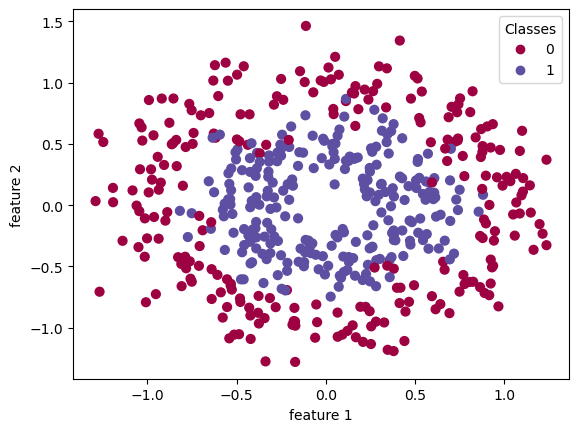

In [12]:
X_np,Y_np = load_circles_dataset( n_samples=500, noise=0.15, factor=0.5)
X=torch.tensor(X_np.T, dtype=torch.float32)
Y=torch.tensor(Y_np.reshape(-1,1), dtype=torch.float32)
print(X.shape, Y.shape)
plot_scatter(X_np,Y_np)

### L Layer Neural Network Model

In [13]:
def L_layer_model(train_X, train_Y, layers_dims, learning_rate=0.0075, num_epochs=2000, activation_L_1="relu", activation_L="sigmoid", print_cost=False):
    """
    L layer neural network with different activation function on output layer option.
    
    Parameters
    ----------
    train_X : Tensor [shape: (#samples, #features)]; dtype=tf.float32
    train_Y : Tensor [shape: (#samples, 1)]; dtype=tf.float32
    layers_dims : list of int; list of number of nodes in each layer

    Returns
    -------
    forward : trained model
    costs : list of cost every 100 iteration
    """
    costs = []                                        # To keep track of the cost
    L = len(layers_dims) # number of layers in the network

    ## Initialize layers
    activations = torch.nn.ModuleDict({ 'sigmoid':torch.nn.Sigmoid(), 'tanh':torch.nn.Tanh(),
                'relu':torch.nn.ReLU(), 'lrelu':torch.nn.LeakyReLU() })
    layers_list = []
    for in_f, out_f in zip(layers_dims, layers_dims[1:-1]):
        layers_list.append(torch.nn.Linear(in_f, out_f))
        layers_list.append(activations[activation_L_1])
    layers_list.append(torch.nn.Linear(layers_dims[-2], layers_dims[-1]))
    layers_list.append(activations[activation_L])
        
    forward = torch.nn.Sequential(*layers_list)
    
    ## Initialize parameters
    np.random.seed(3)
    with torch.no_grad():
        for l in range(1, L):
            init_W = torch.tensor( np.random.randn(layers_dims[l], layers_dims[l-1]) / np.sqrt(layers_dims[l-1]), dtype=torch.float32 )
            init_b = torch.zeros((layers_dims[l], ))
            forward[2*(l-1)].weight.copy_(init_W)
            forward[2*(l-1)].bias.copy_(init_b)
            
    optimizer = torch.optim.Adam(forward.parameters(), lr = learning_rate)

    ## epochs loop
    for i in range(num_epochs): 
        ## forward pass
        train_Y_pred = forward(train_X)       # (209,n_L)=(m,n_L)
        cost = torch.nn.functional.binary_cross_entropy(train_Y_pred, train_Y, reduction="mean")

        ## backward pass
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        ## Record the cost every 100 iterations
        if i % 100 == 0 or i == num_epochs-1:
            costs.append(cost.item())
            if print_cost:
                print(f"Cost in epochs {i+1}, {cost.item()}")
    
    return forward, costs


def plot_costs(costs, learning_rate):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

### Detailed info, plots demo

Cost in epochs 1, 0.6780675649642944
Cost in epochs 101, 0.19989825785160065
Cost in epochs 201, 0.1516697257757187
Cost in epochs 301, 0.14924722909927368
Cost in epochs 401, 0.14798638224601746
Cost in epochs 501, 0.146851047873497
Cost in epochs 601, 0.1443331390619278
Cost in epochs 701, 0.14063860476016998
Cost in epochs 801, 0.13665691018104553
Cost in epochs 901, 0.1340896189212799
Cost in epochs 1001, 0.13207906484603882
Cost in epochs 1101, 0.13059034943580627
Cost in epochs 1201, 0.12956441938877106
Cost in epochs 1301, 0.1288767158985138
Cost in epochs 1401, 0.1282106190919876
Cost in epochs 1501, 0.1276383399963379
Cost in epochs 1601, 0.12725262343883514
Cost in epochs 1701, 0.12688355147838593
Cost in epochs 1801, 0.1261492371559143
Cost in epochs 1901, 0.12564778327941895
Cost in epochs 2000, 0.12537847459316254
train accuracy: 95.80000042915344 %


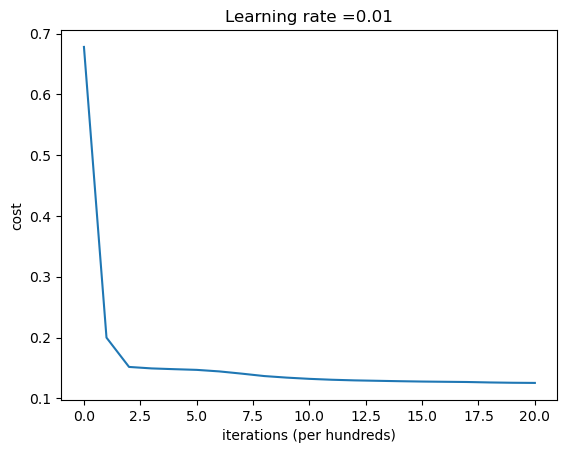

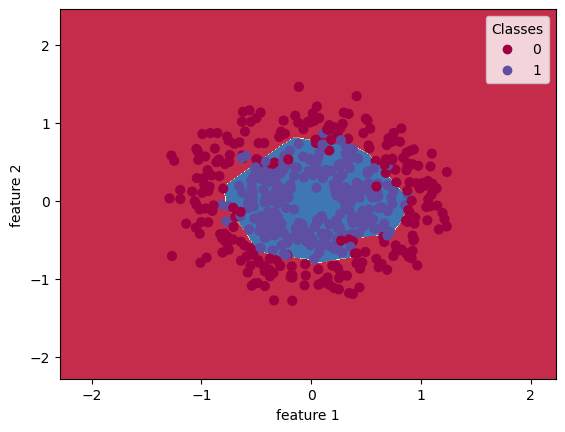

In [14]:
num_epochs=2000; activation_L_1="relu"; activation_L="sigmoid"
learning_rate = 0.01; layers_dims=[X.shape[-1],6,6, 1]

forward, costs = L_layer_model(X, Y, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=True)
Y_pred=forward(X)
acc = binary_accuracy(input=Y_pred.view(-1,), target=Y.view(-1,), threshold=0.5)
print(f"train accuracy: { acc.item() *100 } %")
plot_costs(costs, learning_rate)
plot_decision_boundary(forward, X_np, Y_np)

### Single Neuron Model Run

Cost in epochs 1, 0.757793128490448
Cost in epochs 101, 0.6992443203926086
Cost in epochs 201, 0.6931278109550476
Cost in epochs 301, 0.6929904818534851
Cost in epochs 401, 0.6929899454116821
Cost in epochs 501, 0.6929900050163269
Cost in epochs 601, 0.6929900050163269
Cost in epochs 701, 0.6929900050163269
Cost in epochs 801, 0.6929900050163269
Cost in epochs 901, 0.6929900050163269
Cost in epochs 1001, 0.6929900050163269
Cost in epochs 1101, 0.6929900050163269
Cost in epochs 1201, 0.6929900050163269
Cost in epochs 1301, 0.6929900050163269
Cost in epochs 1401, 0.6929900050163269
Cost in epochs 1501, 0.6929900050163269
Cost in epochs 1601, 0.6929900050163269
Cost in epochs 1701, 0.6929900050163269
Cost in epochs 1801, 0.6929900050163269
Cost in epochs 1901, 0.6929900050163269
Cost in epochs 2000, 0.6929900050163269
train accuracy: 50.199997425079346 %


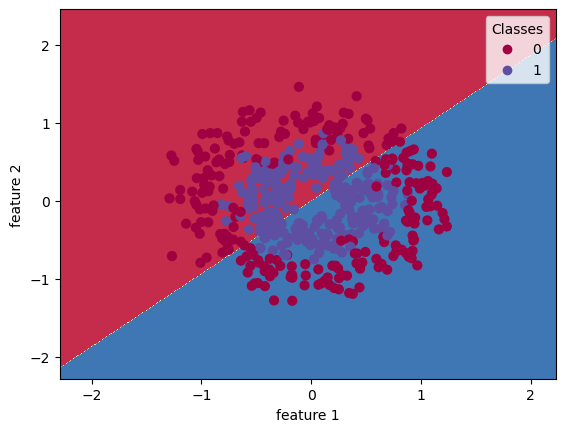

In [15]:
num_epochs=2000; activation_L_1="relu"; activation_L="sigmoid"
learning_rate = 0.01; layers_dims=[X.shape[-1], 1]

forward, costs = L_layer_model(X, Y, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=True)
Y_pred=forward(X)
acc = binary_accuracy(input=Y_pred.view(-1,), target=Y.view(-1,), threshold=0.5)
print(f"train accuracy: { acc.item() *100 } %")
plot_decision_boundary(forward, X_np, Y_np)

### 2 Layers (or 1 hidden layer) Neural Network with 1 neuron in output layer

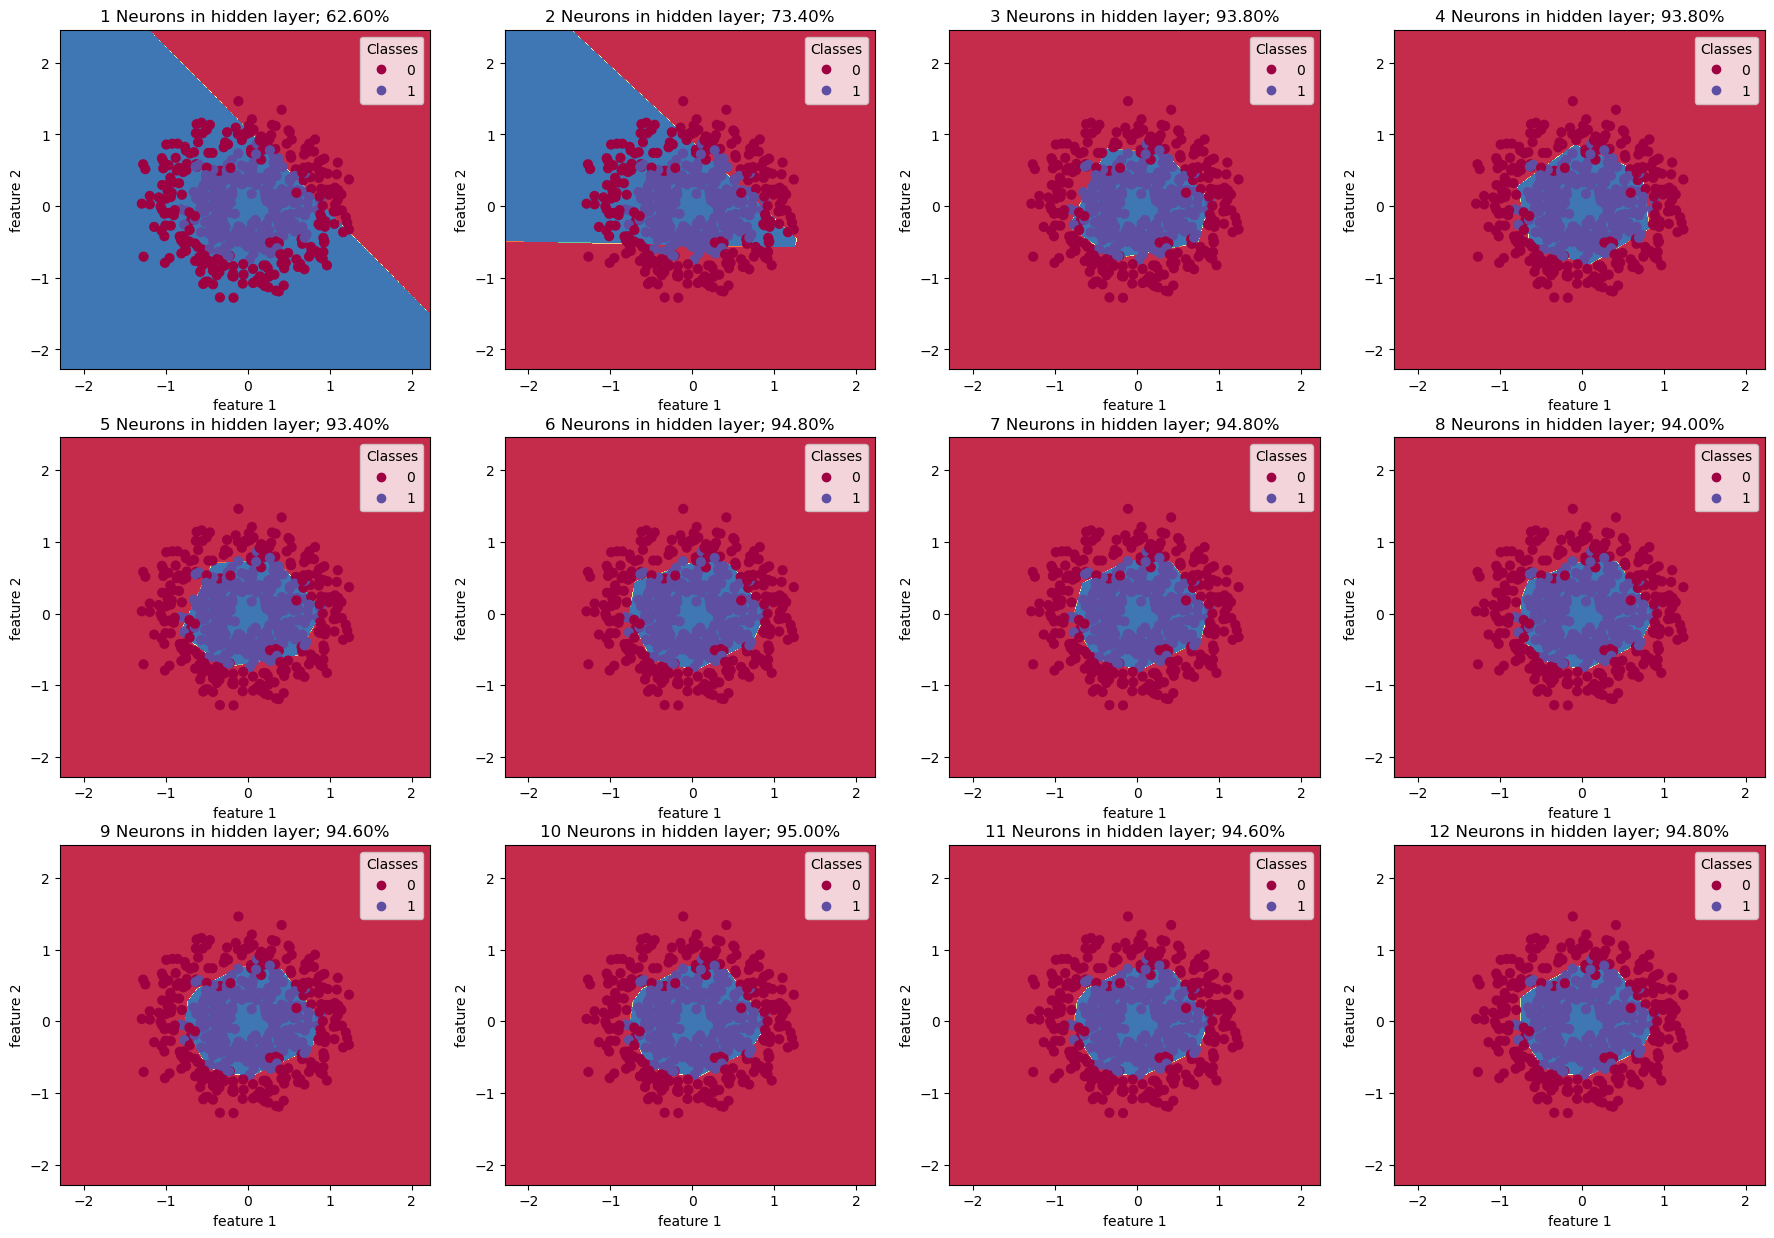

In [16]:
num_epochs=2000; activation_L_1="relu"; activation_L="sigmoid"
learning_rate = 0.01; layers_dims=[X.shape[-1],1, 1]
plt.rcParams['figure.figsize'] = (22.0, 15.0) # width, height
for i in range(1,13):
    layers_dims=[X.shape[-1],i, 1]
    plt.subplot(3, 4, i)
    forward, costs = L_layer_model(X, Y, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
    Y_pred=forward(X)
    acc = binary_accuracy(input=Y_pred.view(-1,), target=Y.view(-1,), threshold=0.5)
    plot_decision_boundary(forward, X_np, Y_np)
    plt.title(f"{i} Neurons in hidden layer; {acc.item()*100:.2f}%")


### 3 Layers (or 2 hidden layer) Neural Network with 1 neuron in output layer

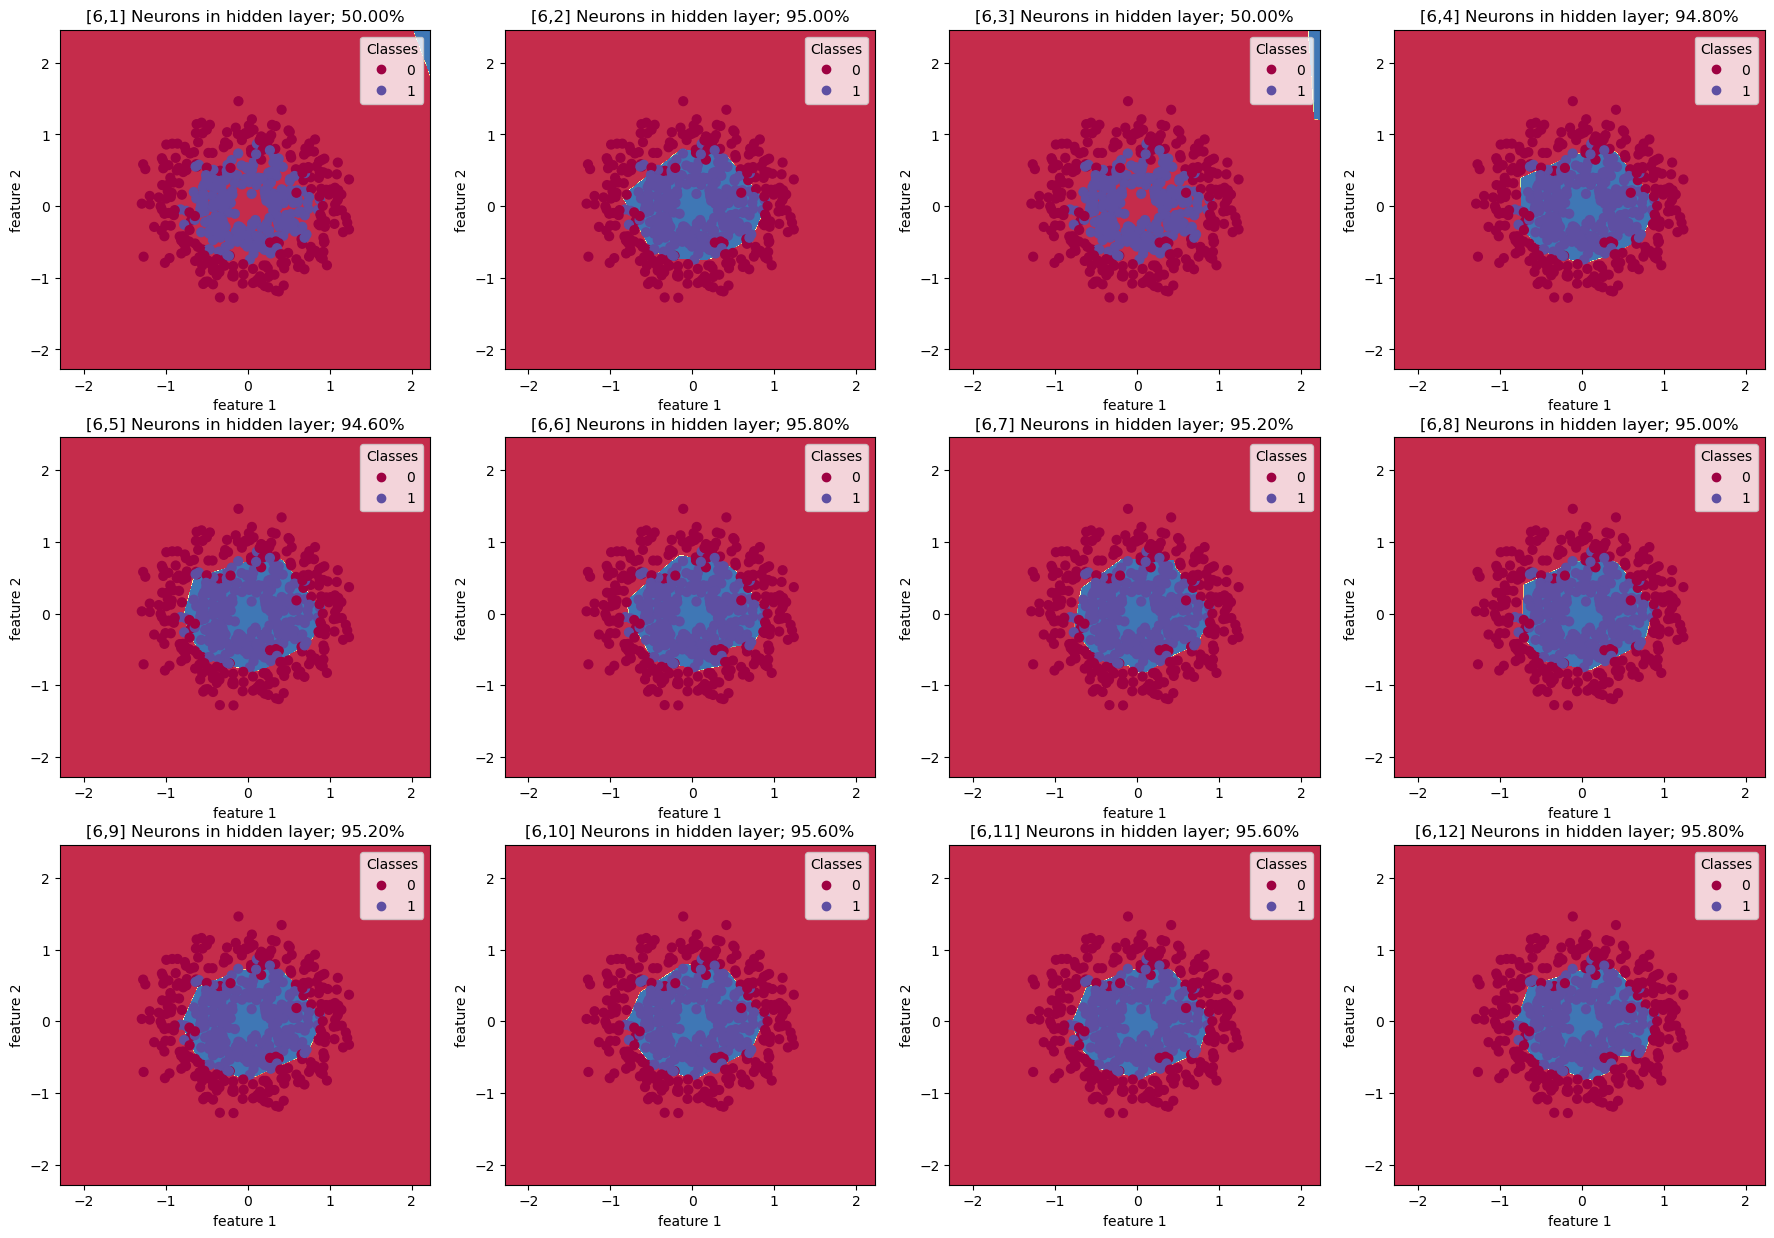

In [17]:
num_epochs=2000; activation_L_1="relu"; activation_L="sigmoid"
learning_rate = 0.01; layers_dims=[X.shape[-1],6,1, 1]
plt.rcParams['figure.figsize'] = (22.0, 15.0) # width, height
for i in range(1,13):
    layers_dims=[X.shape[-1],6, i, 1]
    plt.subplot(3, 4, i)
    forward, costs = L_layer_model(X, Y, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
    Y_pred=forward(X)
    acc = binary_accuracy(input=Y_pred.view(-1,), target=Y.view(-1,), threshold=0.5)
    plot_decision_boundary(forward, X_np, Y_np)
    plt.title(f"[6,{i}] Neurons in hidden layer; {acc.item()*100:.2f}%")

### Conclusion

3 layer neural networks in general give best results and adding more layers is increasing accuracy by much but probably overfitting.

Text(0.5, 1.0, '[6,6] Neurons in hidden layer; 95.80%')

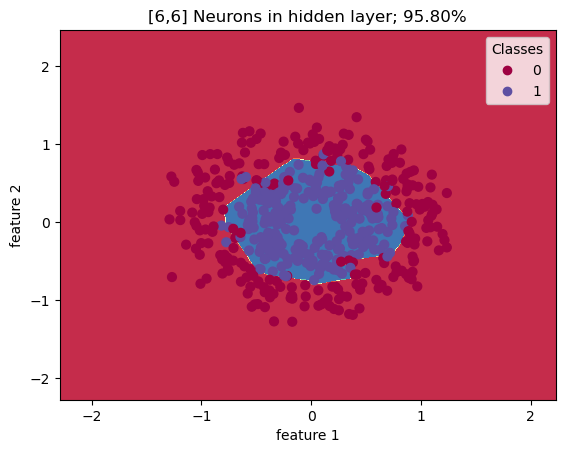

In [18]:
num_epochs=2000; activation_L_1="relu"; activation_L="sigmoid"
learning_rate = 0.01; layers_dims=[X.shape[-1],6,6, 1]
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
forward, costs = L_layer_model(X, Y, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
Y_pred=forward(X)
acc = binary_accuracy(input=Y_pred.view(-1,), target=Y.view(-1,), threshold=0.5)
# print(f"train accuracy: { acc.item() *100 } %")
# plot_costs(costs, learning_rate)
plot_decision_boundary(forward, X_np, Y_np)
plt.title(f"[6,6] Neurons in hidden layer; {acc.item()*100:.2f}%")